In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def sample(d0, d1, n=32):
    
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    
    return torch.cat([ x0,  x1], 0), torch.cat([y0, y1], 0)

In [3]:
# параметры распределений
mean_vector0, cov_matrix0 = torch.zeros(2), 2*torch.eye(2)
mean_vector1, cov_matrix1 = torch.tensor([3, 3], dtype=torch.float32), torch.eye(2)

In [4]:
d0 = torch.distributions.MultivariateNormal(mean_vector0, cov_matrix0)
d1 = torch.distributions.MultivariateNormal(mean_vector1, cov_matrix1)

In [5]:
net = nn.Sequential(nn.Linear(2, 8), 
                    nn.ReLU(), 
                    nn.Linear(8, 1))
print([p.data[0] for p in net.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))

[tensor([-0.5113, -0.2990]), tensor(0.2777), tensor([-0.3048, -0.1146,  0.2249, -0.1788, -0.1107,  0.2709,  0.2406, -0.0943]), tensor(0.0454)]


In [6]:
x_scale, y_scale = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
pos = np.empty(x_scale.shape + (2,))
pos[:, :, 0] = x_scale; pos[:, :, 1] = y_scale

d0_pdf = stats.multivariate_normal(mean=mean_vector0.numpy(), cov=cov_matrix0.numpy()).pdf(pos)
d1_pdf = stats.multivariate_normal(mean=mean_vector1.numpy(), cov=cov_matrix1.numpy()).pdf(pos)

ratio = d1_pdf / (d1_pdf + d0_pdf)

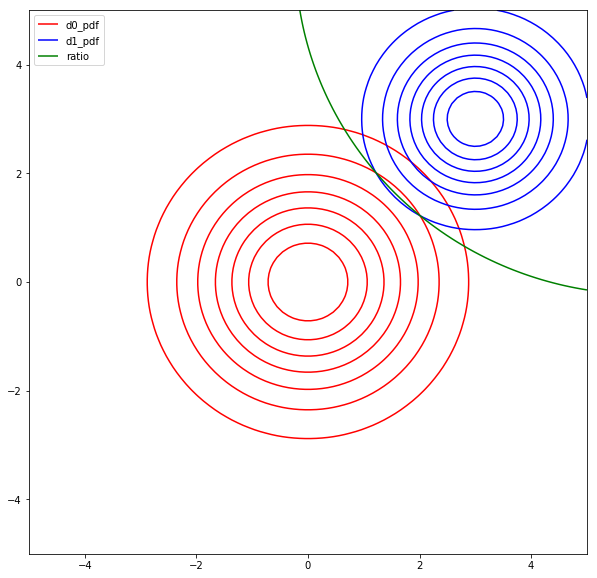

In [7]:
plt.figure(figsize=(10,10))

a = plt.contour(x_scale, y_scale, d0_pdf, colors='red')
b = plt.contour(x_scale, y_scale, d1_pdf, colors='blue')
c = plt.contour(x_scale, y_scale, ratio, colors='green', levels=[0, 0.5, 1])

labels = ['d0_pdf', 'd1_pdf','ratio']
a.collections[0].set_label('d0_pdf')
b.collections[0].set_label('d1_pdf')
c.collections[0].set_label('ratio')

plt.legend(loc='upper left')
plt.show()

In [8]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(net(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.610770
Ошибка после 1 итераций: 0.544708
Ошибка после 2 итераций: 0.472826
Ошибка после 3 итераций: 0.412013
Ошибка после 4 итераций: 0.367823
Ошибка после 5 итераций: 0.334488
Ошибка после 6 итераций: 0.309215
Ошибка после 7 итераций: 0.288903
Ошибка после 8 итераций: 0.271561
Ошибка после 9 итераций: 0.256023
Ошибка после 10 итераций: 0.241898
Ошибка после 11 итераций: 0.231148
Ошибка после 12 итераций: 0.220307
Ошибка после 13 итераций: 0.211769
Ошибка после 14 итераций: 0.202438
Ошибка после 15 итераций: 0.194995
Ошибка после 16 итераций: 0.188746
Ошибка после 17 итераций: 0.184651
Ошибка после 18 итераций: 0.178527
Ошибка после 19 итераций: 0.172751


In [9]:
x_and_y_tensor = torch.tensor(np.c_[x_scale.ravel(), y_scale.ravel()], dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(net(x_and_y_tensor)).numpy()

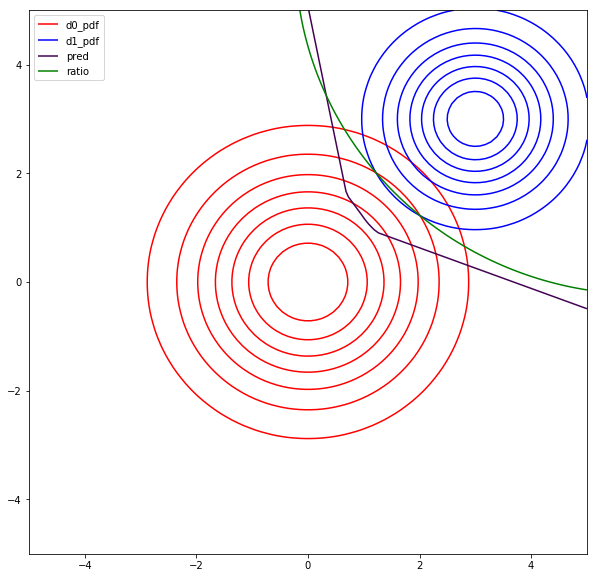

In [10]:
plt.figure(figsize=(10,10))

a = plt.contour(x_scale, y_scale, d0_pdf, colors='red')
b = plt.contour(x_scale, y_scale, d1_pdf, colors='blue')
c = plt.contour(x_scale, y_scale, dist.reshape(x_scale.shape), levels=[0, 0.5, 1])
d = plt.contour(x_scale, y_scale, ratio, colors='green', levels=[0, 0.5, 1])

labels = ['d0_pdf', 'd1_pdf','ratio', 'pred']
a.collections[0].set_label('d0_pdf')
b.collections[0].set_label('d1_pdf')
c.collections[0].set_label('pred')
d.collections[0].set_label('ratio')


plt.legend(loc='upper left')
plt.show()